In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R01CS"]

dtype = torch.float32

In [3]:
sequences = [utils.sequences_from_file(experiment_id, round_id) for round_id in round_ids]

In [4]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [5]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [6]:
L, q = sequences_oh[0][0].shape

k = torch.randn(L, q, dtype=dtype) * 1e-4
h_beads = torch.randn(L, q, dtype=dtype) * 1e-4
h = torch.randn(L, q, dtype=dtype) * 1e-4
J = utils.rand_coupling_matrix(L, q, dtype=dtype, rescaling=1e-4)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(-1)

selected_modes = torch.BoolTensor(
    [[1, 1, 0],
     [0, 1, 0]]
)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
beads = energy_models.IndepSites(h_beads)
unbound_sel = energy_models.ConstantEnergy(-10)

ps = selex_distribution.MultiModeDistribution(potts, beads, unbound_sel, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [7]:
device = torch.device("cpu")

In [8]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [9]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [10]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [ ]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 200

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                              ] Epoch: 0/200 [00:00, ?it/s]

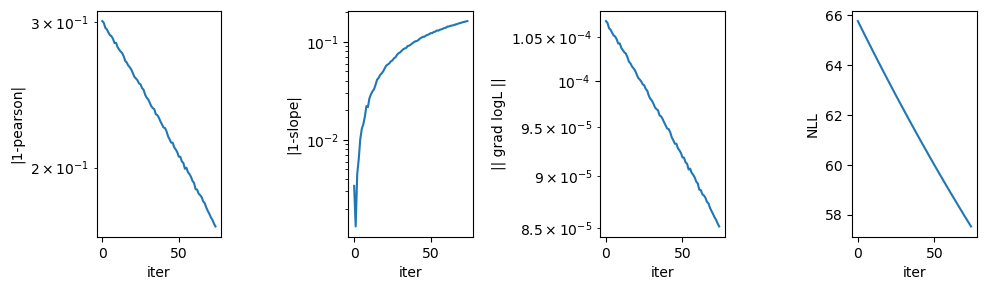

In [12]:
callbacks[0].plot();

(0.0, 1.1)

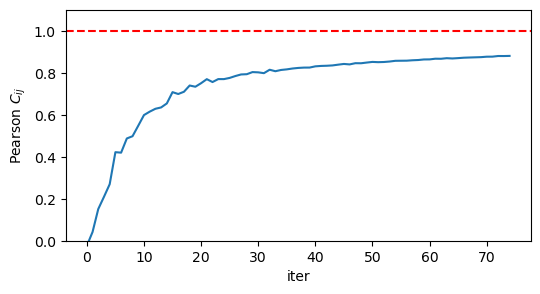

In [13]:
fig, ax = callbacks[1].plot()
ax.axhline(1, color='r', linestyle='--')
ax.set_ylim((0,1.1))

In [14]:
potts = energy_models.Potts(model.selection.modes[0].J.data, model.selection.modes[0].h.data)

<IPython.core.display.Latex object>

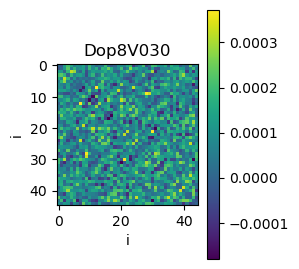

In [15]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()
# potts_zerosum = potts

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

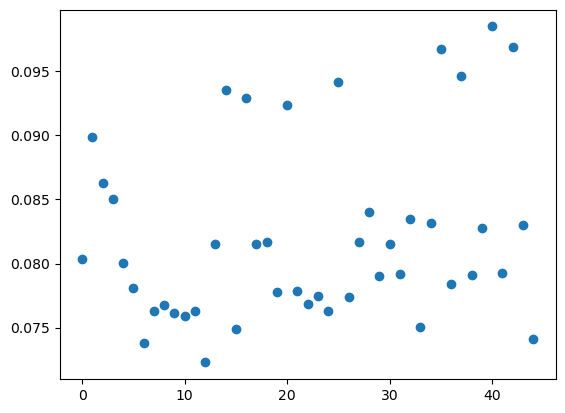

In [16]:
h_norm_bead = torch.sqrt(torch.square(potts_zerosum.h.cpu().detach().clone()).sum(1))
plt.scatter(range(L), h_norm_bead)